# Loading Required Libraries

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Data Reading 
import os
from glob import glob
from PIL import Image
# Data Processing 
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
# Data Modeling & Model Evaluation
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models 
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.applications.vgg16 import VGG16
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
# Grad-CAM
import keras
import matplotlib.cm as cm
from keras.models import Model
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from tensorflow.keras.applications.resnet50 import ResNet50

# Reading The Data

In [37]:
levels = ['Normal', 'COVID']
path = "../Dataset/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)
data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})
samples = 13808
data.head()

,image_file,corona_result,path
0,Normal/Normal-1.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...
1,Normal/Normal-10.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...
2,Normal/Normal-100.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...
3,Normal/Normal-1000.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...
4,Normal/Normal-10000.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...


In [38]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 13808


# Exploratory Data Analysis

## 1. Count Plot

In [39]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

## 2. Image Samples

In [40]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))
data.head()

,image_file,corona_result,path,image
0,Normal/Normal-1.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Normal/Normal-10.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...,"[[9, 9, 9, 8, 8, 7, 6, 4, 3, 2, 1, 1, 1, 0, 0,..."
2,Normal/Normal-100.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...,"[[0, 0, 0, 0, 12, 57, 75, 95, 111, 117, 119, 1..."
3,Normal/Normal-1000.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...,"[[0, 6, 23, 51, 66, 69, 71, 67, 97, 96, 101, 1..."
4,Normal/Normal-10000.png,Negative,../Dataset/COVID-19_Radiography_Dataset/Normal...,"[[136, 118, 106, 100, 96, 93, 91, 88, 87, 87, ..."


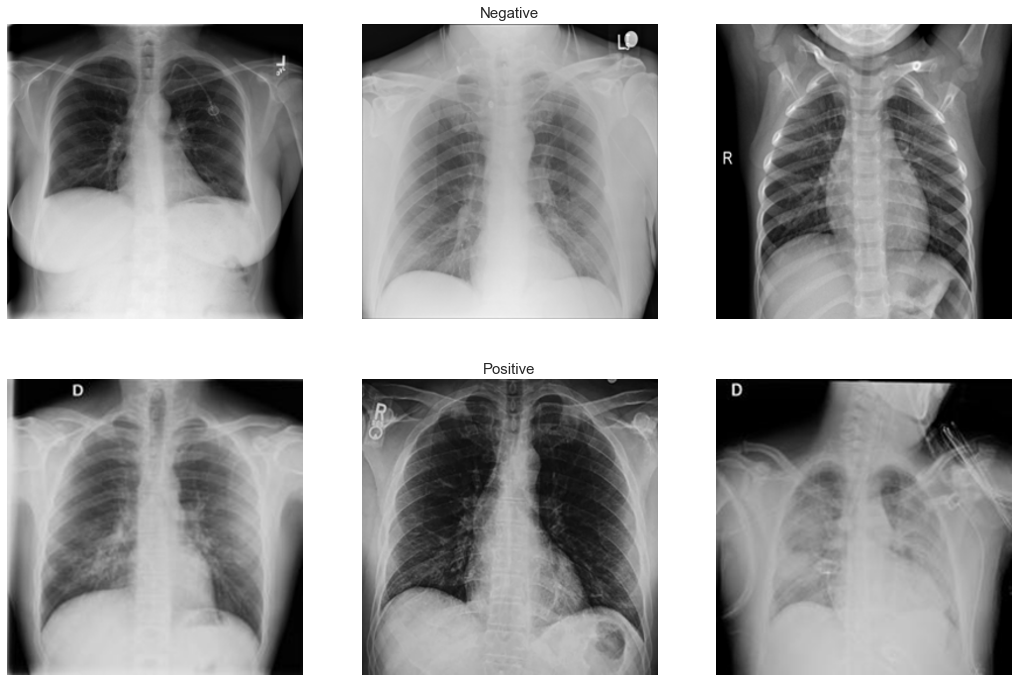

In [41]:
n_samples = 3
fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))
for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

## 3. Random Image Analysis

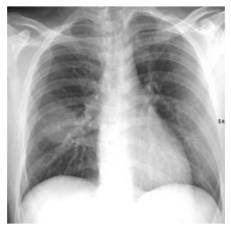

In [42]:
plt.figure()
image = cv2.imread("../Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1002.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [43]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 5


We observe that the image has 3 channels, hence it in in RGB scale even if these are X-ray images.

# 4. B-Channel ไม่จำเป็น

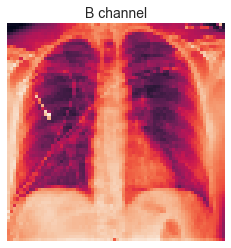

In [125]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

# 5. Ben Graham's Method

First, we convert the images to greyscale and then apply Gaussian blur to them.

In [45]:
all_covid = []
all_normal = []
all_normal.extend(glob(os.path.join(path, "Normal/*.png")))
all_covid.extend(glob(os.path.join(path, "COVID/*.png")))
random.shuffle(all_normal)
random.shuffle(all_covid)
images = all_normal[:50] + all_covid[:50]

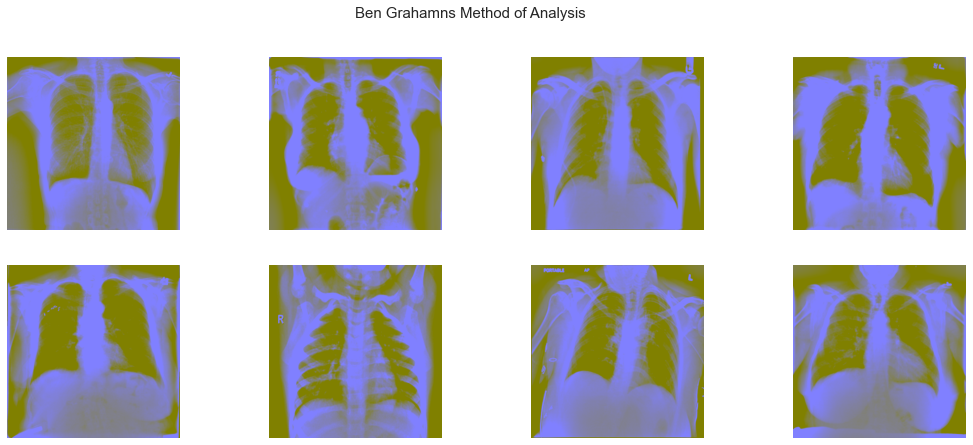

In [46]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

# 6. Albumentations Visualization

In [47]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
    plt.show()

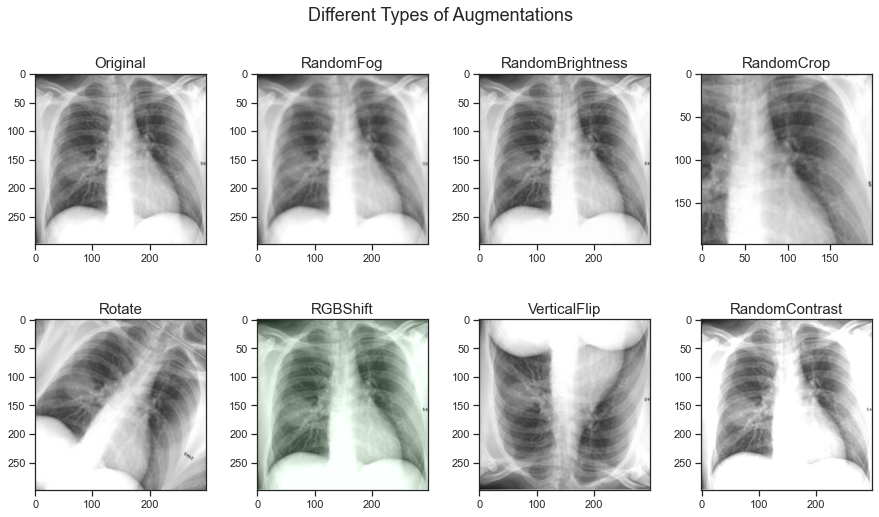

In [48]:
chosen_image = cv2.imread("../Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1002.png")
albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)
img_matrix_list.insert(0,chosen_image)    
titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]
plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

# 7. Image Value Distribution

In [49]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []
for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())
imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val
imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

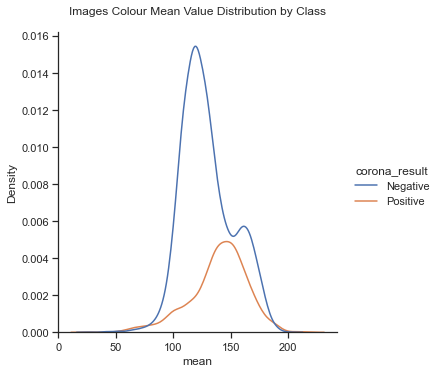

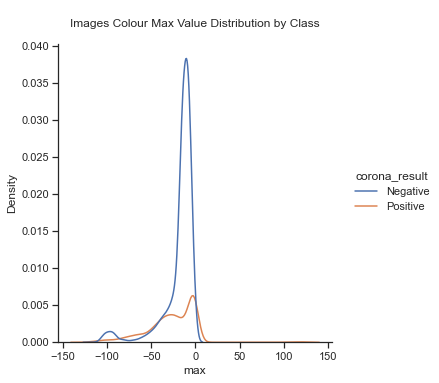

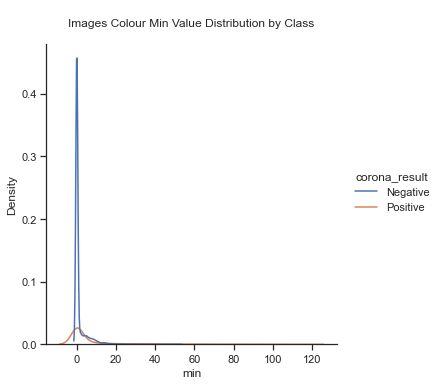

In [50]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'corona_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);
ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);
ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'corona_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

### The Mean vs Density plot insights for pixels:
1. The max pixel value for Covid Negative cases is greater than 0.014 and less than 0.016.
2. The max pixel value for Covid Positive cases is greater than 0.004 & less than 0.006.
### The Max vs Density plot insights for pixels:
1. The max pixel value for Covid Negative cases is greater than 0.035 and less than 0.040.
2. The max pixel value for Covid Positive cases is 0.005.
### The Min vs Density plot insights for pixels:
1. The max pixel value for Covid Negative cases is greater than 0.4.
2. The max pixel value for Covid Positive cases is greater than 0.0 and less than 0.1.

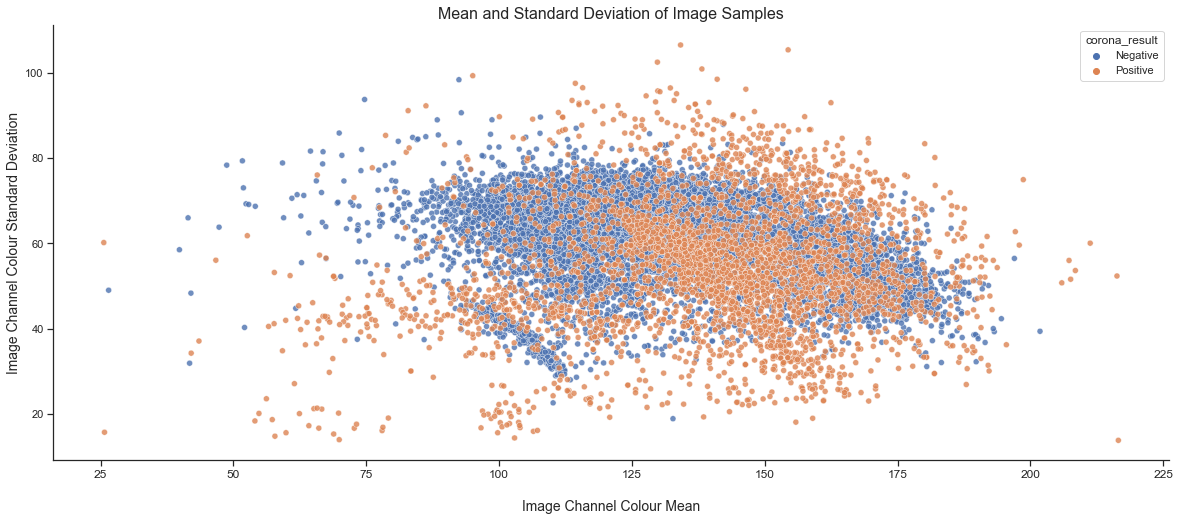

In [51]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

We observe that there are 2 clusters formed, one for Covid Positive, one for Covid Negative and both have several overlappings. Overlapping Color Mean range: (100 - 175)   
     We observe that for pixels having Std Deviation below 30 are all Covid Positive Images (Orange Colored).

<Figure size 720x576 with 0 Axes>

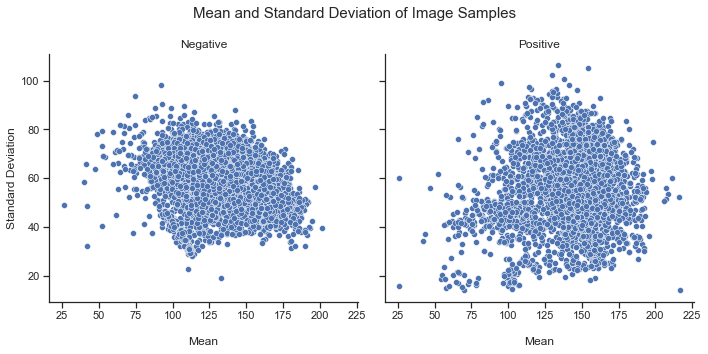

In [52]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

Comparing both Scatter plots, we observe that Postivie Samples have outliers (pixel points).

# 8. Self Insights

# Data Modeling
Train Test Split

In [53]:
all_data = []
# Storing images and their labels into a list for further Train Test split
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [54]:
x = []
y = []
for image, label in all_data:
    x.append(image)
    y.append(label)
# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


## CNN Model

In [55]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(units = 2))
cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [56]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 56s 1s/step - loss: 0.6167 - accuracy: 0.7325 - val_loss: 0.5233 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 53s 1s/step - loss: 0.5135 - accuracy: 0.7330 - val_loss: 0.4399 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 53s 1s/step - loss: 0.4634 - accuracy: 0.7330 - val_loss: 0.4132 - val_accuracy: 0.7638
Epoch 4/50
39/39 [==============================] - 53s 1s/step - loss: 0.4157 - accuracy: 0.7925 - val_loss: 0.3549 - val_accuracy: 0.8353
Epoch 5/50
39/39 [==============================] - 54s 1s/step - loss: 0.3781 - accuracy: 0.8397 - val_loss: 0.3170 - val_accuracy: 0.8643
Epoch 6/50
39/39 [==============================] - 53s 1s/step - loss: 0.3459 - accuracy: 0.8609 - val_loss: 0.3065 - val_accuracy: 0.8751
Epoch 7/50
39/39 [==============================] - 52s 1s/step - loss: 0.3266 - accuracy: 0.8773 - val_loss: 0.2883 - val_accuracy: 0.8869
Epoch 8/50
39/39 [==

In [126]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)
yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)
yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

311/311 [==============================] - 12s 39ms/step
[[ 0.01792115 -0.30739036]
 [10.581436   -5.9744177 ]
 [-0.29116696  0.24188499]
 ...
 [ 4.65106    -4.069542  ]
 [ 1.8644916   1.006615  ]
 [ 6.7398577  -2.9959297 ]]
87/87 [==============================] - 4s 41ms/step


## Model Evaluation CNN 


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7287
           1       0.94      0.85      0.89      2654

    accuracy                           0.95      9941
   macro avg       0.94      0.91      0.93      9941
weighted avg       0.95      0.95      0.94      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.8478
Specificity on Train Data:  0.9812
Accuracy on Train Data:  0.9456
Precision on Train Data:  0.9426
F1 Score on Train Data:  0.8927
--------------------------------------------------------------------------


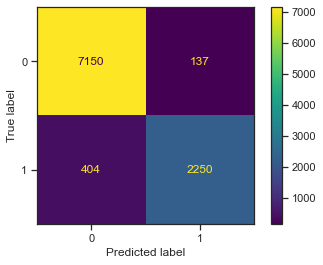

In [58]:
print("\n-----------------------------{}-----------------------------\n".format("Convolution Neural Network"))
cm_train = confusion_matrix(y_train, yp_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
t1 = ConfusionMatrixDisplay(cm_train)
print("Classification Report for Train Data\n")
print(classification_report(y_train, yp_train)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------Convolution Neural Network-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       844
           1       0.90      0.80      0.85       261

    accuracy                           0.93      1105
   macro avg       0.92      0.89      0.90      1105
weighted avg       0.93      0.93      0.93      1105

--------------------------------------------------------------------------
Recall on Val Data:  0.8046
Specificity on Val Data:  0.9727
Accuracy on Val Data:  0.933
Precision on Val Data:  0.9013
F1 Score on Val Data:  0.8502
--------------------------------------------------------------------------


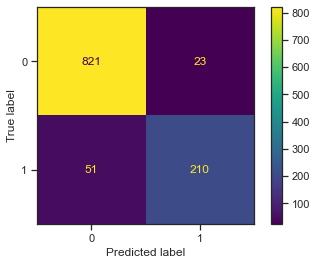

In [59]:
print("\n-----------------------------{}-----------------------------\n".format("Convolution Neural Network"))
cm_val = confusion_matrix(y_val, yp_val)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val, yp_val))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
print("--------------------------------------------------------------------------")
t2.plot()


-----------------------------Convolution Neural Network-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2061
           1       0.91      0.80      0.85       701

    accuracy                           0.93      2762
   macro avg       0.92      0.89      0.90      2762
weighted avg       0.93      0.93      0.93      2762

--------------------------------------------------------------------------
Recall on Test Data:  0.7974
Specificity on Test Data:  0.9743
Accuracy on Test Data:  0.9294
Precision on Test Data:  0.9134
F1 Score Test Data:  0.8515
--------------------------------------------------------------------------


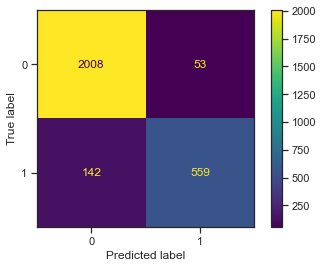

In [60]:
print("\n-----------------------------{}-----------------------------\n".format("Convolution Neural Network"))
cm_test = confusion_matrix(y_test, yp_test)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test, yp_test))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
print("--------------------------------------------------------------------------")
t3.plot()

In [61]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


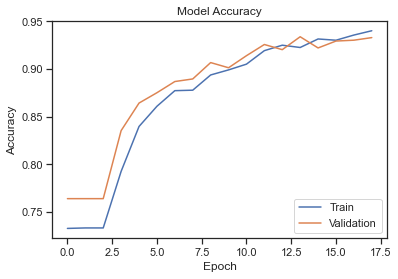

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

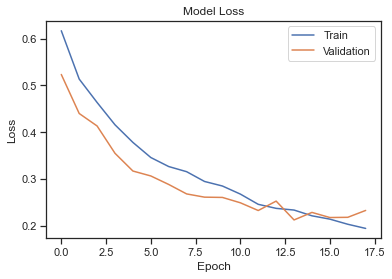

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

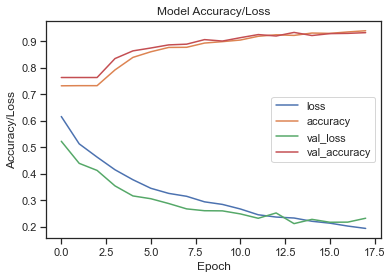

In [64]:
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

We observe that Train & Validation Accuracy's Curve slightly overlap and same with Loss Curve.

Hence, Overfitting is avoided, this is possible because of Dropout Regularization & Early Stopping Metrics.

## VGG16 Model

In [65]:
baseModel = VGG16(input_shape = (70, 70, 3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

VGG16_Model = baseModel.output
VGG16_Model = AveragePooling2D()(VGG16_Model)
VGG16_Model = Flatten()(VGG16_Model)
VGG16_Model = Dense(128, activation="relu")(VGG16_Model)
VGG16_Model = Dropout(0.2)(VGG16_Model)
VGG16_Model = Dense(3, activation='softmax')(VGG16_Model)

model = Model(inputs=baseModel.input, outputs=VGG16_Model)

In [66]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 70, 70, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 70, 70, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 35, 35, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 35, 35, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 35, 35, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 17, 17, 128)       0     

In [67]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [68]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)
epochs = 50
history_2 = model.fit(x_train, y_train,validation_data= (x_val, y_val), epochs = 50,batch_size = 256,verbose = 1)

Epoch 1/50


d:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



39/39 [==============================] - 62s 2s/step - loss: 0.4893 - accuracy: 0.7703 - val_loss: 0.3755 - val_accuracy: 0.8326
Epoch 2/50
39/39 [==============================] - 59s 2s/step - loss: 0.3632 - accuracy: 0.8395 - val_loss: 0.3400 - val_accuracy: 0.8498
Epoch 3/50
39/39 [==============================] - 60s 2s/step - loss: 0.3369 - accuracy: 0.8558 - val_loss: 0.3225 - val_accuracy: 0.8643
Epoch 4/50
39/39 [==============================] - 60s 2s/step - loss: 0.3195 - accuracy: 0.8604 - val_loss: 0.3056 - val_accuracy: 0.8697
Epoch 5/50
39/39 [==============================] - 59s 2s/step - loss: 0.3066 - accuracy: 0.8688 - val_loss: 0.3009 - val_accuracy: 0.8724
Epoch 6/50
39/39 [==============================] - 59s 2s/step - loss: 0.2936 - accuracy: 0.8759 - val_loss: 0.2820 - val_accuracy: 0.8787
Epoch 7/50
39/39 [==============================] - 59s 2s/step - loss: 0.2897 - accuracy: 0.8741 - val_loss: 0.2761 - val_accuracy: 0.8860
Epoch 8/50
39/39 [=============

In [69]:
yp_train_vgg = model.predict(x_train)
yp_train_vgg = np.argmax(yp_train_vgg, axis = 1)
yp_val_vgg = model.predict(x_val)
yp_val_vgg = np.argmax(yp_val_vgg, axis = 1)
yp_test_vgg = model.predict(x_test)
yp_test_vgg = np.argmax(yp_test_vgg, axis = 1)

87/87 [==============================] - 16s 181ms/step


## Model Evaluation VGG16


-----------------------------VGG16-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7287
           1       0.93      0.89      0.91      2654

    accuracy                           0.95      9941
   macro avg       0.95      0.93      0.94      9941
weighted avg       0.95      0.95      0.95      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.8892
Specificity on Train Data:  0.9763
Accuracy on Train Data:  0.953
Precision on Train Data:  0.9317
F1 Score on Train Data:  0.91
--------------------------------------------------------------------------


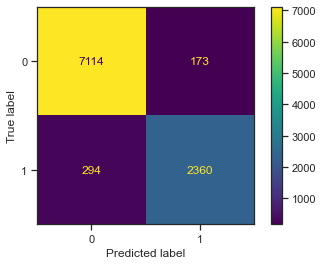

In [70]:
print("\n-----------------------------{}-----------------------------\n".format("VGG16"))
cm_train = confusion_matrix(y_train, yp_train_vgg)
t1 = ConfusionMatrixDisplay(cm_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
print("Classification Report for Train Data\n")
print(classification_report(y_train, yp_train_vgg)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train, yp_train_vgg),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train_vgg),4))
print("Precision on Train Data: ", round(precision_score(y_train, yp_train_vgg),4))
print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train_vgg),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------VGG16-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       844
           1       0.88      0.80      0.84       261

    accuracy                           0.93      1105
   macro avg       0.91      0.89      0.90      1105
weighted avg       0.93      0.93      0.93      1105

--------------------------------------------------------------------------
Recall on Val Data:  0.8046
Specificity on Val Data:  0.9668
Accuracy on Val Data:  0.9285
Precision on Val Data:  0.8824
F1 Score on Val Data:  0.8417
--------------------------------------------------------------------------


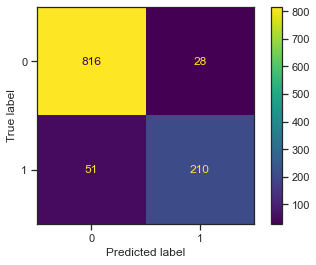

In [71]:
print("\n-----------------------------{}-----------------------------\n".format("VGG16"))
cm_val = confusion_matrix(y_val, yp_val_vgg)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val, yp_val_vgg))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val, yp_val_vgg),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val_vgg),4))
print("Precision on Val Data: ", round(precision_score(y_val, yp_val_vgg),4))
print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val_vgg),4))
print("--------------------------------------------------------------------------")
t2.plot()


-----------------------------VGG16-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2061
           1       0.87      0.85      0.86       701

    accuracy                           0.93      2762
   macro avg       0.91      0.90      0.90      2762
weighted avg       0.93      0.93      0.93      2762

--------------------------------------------------------------------------
Recall on Test Data:  0.8459
Specificity on Test Data:  0.9554
Accuracy on Test Data:  0.9276
Precision on Test Data:  0.8657
F1 Score Test Data:  0.8557
--------------------------------------------------------------------------


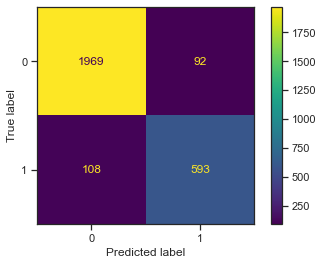

In [72]:
print("\n-----------------------------{}-----------------------------\n".format("VGG16"))
cm_test = confusion_matrix(y_test, yp_test_vgg)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test, yp_test_vgg))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test, yp_test_vgg), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test_vgg), 4))
print("Precision on Test Data: ", round(precision_score(y_test, yp_test_vgg), 4))
print("F1 Score Test Data: ", round(f1_score(y_test, yp_test_vgg), 4))
print("--------------------------------------------------------------------------")
t3.plot()

In [73]:
print(history_2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


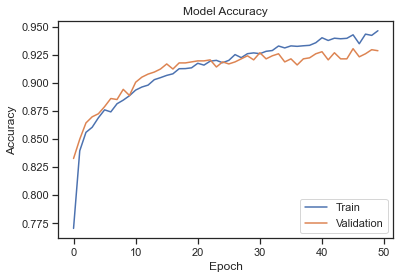

In [74]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

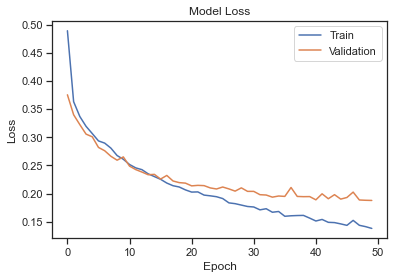

In [75]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

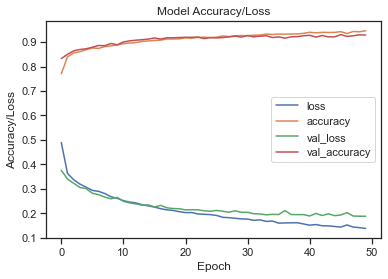

In [76]:
pd.DataFrame(history_2.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

## EfficientNetB3 Model

In [77]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(70,70,3), pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=0.3, seed=123)(x)  
output=Dense(128, activation='relu')(x)
x=Dropout(rate=0.5, seed=123)(x)  
output=Dense(64, activation='relu')(x)
x=Dropout(rate=0.2, seed=123)(x) 
output=Dense(16, activation='relu')(x)
modelB3=Model(inputs=base_model.input, outputs=output)
modelB3.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy']) 

In [78]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
#tf.random.set_seed(42)
history_B3 = modelB3.fit(x_train, y_train,epochs = 50, batch_size = 256,  validation_data = (x_val, y_val),validation_steps=None,  shuffle=False,  initial_epoch=0,callbacks = [es])

Epoch 1/50
39/39 [==============================] - 220s 5s/step - loss: 7.2781 - accuracy: 0.7979 - val_loss: 7.6971 - val_accuracy: 0.2362
Epoch 2/50
39/39 [==============================] - 201s 5s/step - loss: 3.4521 - accuracy: 0.9563 - val_loss: 3.6689 - val_accuracy: 0.2362
Epoch 3/50
39/39 [==============================] - 201s 5s/step - loss: 1.6493 - accuracy: 0.9781 - val_loss: 2.2286 - val_accuracy: 0.2362
Epoch 4/50
39/39 [==============================] - 201s 5s/step - loss: 0.9000 - accuracy: 0.9803 - val_loss: 3.1093 - val_accuracy: 0.2362
Epoch 5/50
39/39 [==============================] - 201s 5s/step - loss: 0.5411 - accuracy: 0.9766 - val_loss: 1.8438 - val_accuracy: 0.2362
Epoch 6/50
39/39 [==============================] - 201s 5s/step - loss: 0.3419 - accuracy: 0.9858 - val_loss: 2.1363 - val_accuracy: 0.2362
Epoch 7/50
39/39 [==============================] - 201s 5s/step - loss: 0.2547 - accuracy: 0.9900 - val_loss: 2.3679 - val_accuracy: 0.2362
Epoch 8/50
39

In [79]:
yp_train_b3 = modelB3.predict(x_train)
yp_train_b3 = np.argmax(yp_train_b3, axis = 1)
yp_val_b3 = modelB3.predict(x_val)
yp_val_b3 = np.argmax(yp_val_b3, axis = 1)
yp_test_b3 = modelB3.predict(x_test)
yp_test_b3 = np.argmax(yp_test_b3, axis = 1)

87/87 [==============================] - 14s 163ms/step


## Model Evaluation EfficientNetB3


-----------------------------EfficientNetB3-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7287
           1       0.27      1.00      0.42      2654

    accuracy                           0.27      9941
   macro avg       0.13      0.50      0.21      9941
weighted avg       0.07      0.27      0.11      9941

--------------------------------------------------------------------------
Recall on Train Data:  1.0
Specificity on Train Data:  0.0
Accuracy on Train Data:  0.267
Precision on Train Data:  0.267
F1 Score on Train Data:  0.4214
--------------------------------------------------------------------------


d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



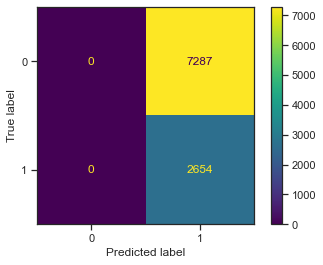

In [80]:
print("\n-----------------------------{}-----------------------------\n".format("EfficientNetB3"))
cm_train = confusion_matrix(y_train, yp_train_b3)
t1 = ConfusionMatrixDisplay(cm_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
print("Classification Report for Train Data\n")
print(classification_report(y_train, yp_train_b3)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train, yp_train_b3),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train_b3),4))
print("Precision on Train Data: ", round(precision_score(y_train, yp_train_b3),4))
print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train_b3),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------EfficientNetB3-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       844
           1       0.24      1.00      0.38       261

    accuracy                           0.24      1105
   macro avg       0.12      0.50      0.19      1105
weighted avg       0.06      0.24      0.09      1105

--------------------------------------------------------------------------
Recall on Val Data:  1.0
Specificity on Val Data:  0.0
Accuracy on Val Data:  0.2362
Precision on Val Data:  0.2362
F1 Score on Val Data:  0.3821
--------------------------------------------------------------------------


d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



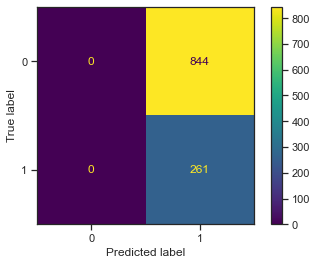

In [81]:
print("\n-----------------------------{}-----------------------------\n".format("EfficientNetB3"))
cm_val = confusion_matrix(y_val, yp_val_b3)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val, yp_val_b3))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val, yp_val_b3),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val_b3),4))
print("Precision on Val Data: ", round(precision_score(y_val, yp_val_b3),4))
print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val_b3),4))
print("--------------------------------------------------------------------------")
t2.plot() 


-----------------------------EfficientNetB3-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2061
           1       0.25      1.00      0.40       701

    accuracy                           0.25      2762
   macro avg       0.13      0.50      0.20      2762
weighted avg       0.06      0.25      0.10      2762

--------------------------------------------------------------------------
Recall on Test Data:  1.0
Specificity on Test Data:  0.0
Accuracy on Test Data:  0.2538
Precision on Test Data:  0.2538
F1 Score Test Data:  0.4049
--------------------------------------------------------------------------


d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



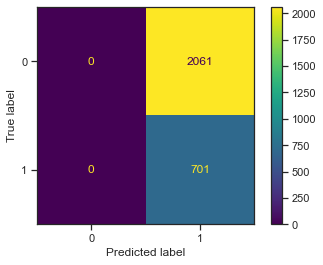

In [82]:
print("\n-----------------------------{}-----------------------------\n".format("EfficientNetB3"))
cm_test = confusion_matrix(y_test, yp_test_b3)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test, yp_test_b3))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test, yp_test_b3), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test_b3), 4))
print("Precision on Test Data: ", round(precision_score(y_test, yp_test_b3), 4))
print("F1 Score Test Data: ", round(f1_score(y_test, yp_test_b3), 4))
print("--------------------------------------------------------------------------")
t3.plot() 

In [83]:
print(history_B3.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


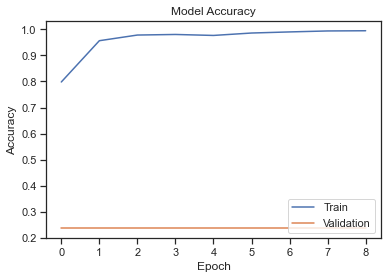

In [84]:
plt.plot(history_B3.history['accuracy'])
plt.plot(history_B3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

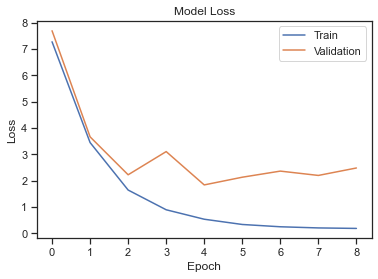

In [85]:
plt.plot(history_B3.history['loss'])
plt.plot(history_B3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

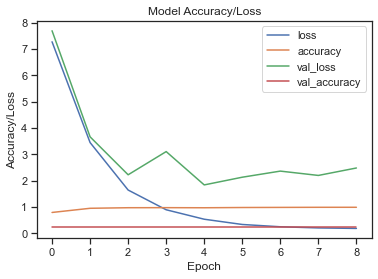

In [86]:
pd.DataFrame(history_B3.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

# Resnet 50 Model

In [87]:
base_model = ResNet50(input_shape= (70,70,3), weights = "imagenet", include_top=False)
x=base_model.output
x=GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
out=Dense(4,activation='softmax')(x)
modelres=Model(inputs=base_model.input,outputs=out)

In [88]:
modelres.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 76, 76, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 35, 35, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 35, 35, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [89]:
modelres.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [90]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_data', mode = 'min', verbose = 1, patience = 4)
history_4 = modelres.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50


d:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



39/39 [==============================] - 257s 6s/step - loss: 0.1960 - accuracy: 0.9215 - val_loss: 26.0255 - val_accuracy: 0.2362
Epoch 2/50
39/39 [==============================] - 251s 6s/step - loss: 0.0474 - accuracy: 0.9843 - val_loss: 0.8769 - val_accuracy: 0.2362
Epoch 3/50
39/39 [==============================] - 250s 6s/step - loss: 0.0355 - accuracy: 0.9883 - val_loss: 9.0138 - val_accuracy: 0.2362
Epoch 4/50
39/39 [==============================] - 251s 6s/step - loss: 0.0216 - accuracy: 0.9922 - val_loss: 4.5561 - val_accuracy: 0.2362
Epoch 5/50
39/39 [==============================] - 252s 6s/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 4.8950 - val_accuracy: 0.2362
Epoch 6/50
39/39 [==============================] - 252s 6s/step - loss: 0.0233 - accuracy: 0.9925 - val_loss: 4.1900 - val_accuracy: 0.2362
Epoch 7/50
39/39 [==============================] - 253s 6s/step - loss: 0.0164 - accuracy: 0.9937 - val_loss: 2.0779 - val_accuracy: 0.2362
Epoch 8/50
39/39 [=====

In [91]:
yp_train_res = model.predict(x_train)
yp_train_res = np.argmax(yp_train_res, axis = 1)
yp_val_res = model.predict(x_val)
yp_val_res = np.argmax(yp_val_res, axis = 1)
yp_test_res = model.predict(x_test)
yp_test_res = np.argmax(yp_test_res, axis = 1)

87/87 [==============================] - 16s 183ms/step


# Model Evaluation Resnet 50


-----------------------------Resnet 50-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7287
           1       0.93      0.89      0.91      2654

    accuracy                           0.95      9941
   macro avg       0.95      0.93      0.94      9941
weighted avg       0.95      0.95      0.95      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.8892
Specificity on Train Data:  0.9763
Accuracy on Train Data:  0.953
Precision on Train Data:  0.9317
F1 Score on Train Data:  0.91
--------------------------------------------------------------------------


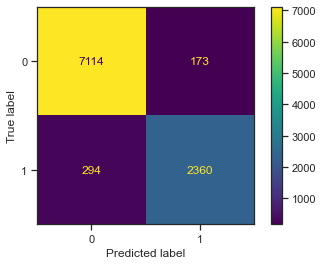

In [92]:
print("\n-----------------------------{}-----------------------------\n".format("Resnet 50"))
cm_train = confusion_matrix(y_train, yp_train_res)
t1 = ConfusionMatrixDisplay(cm_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
print("Classification Report for Train Data\n")
print(classification_report(y_train, yp_train_res)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train, yp_train_res),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train_res),4))
print("Precision on Train Data: ", round(precision_score(y_train, yp_train_res),4))
print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train_res),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------Resnet 50-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       844
           1       0.88      0.80      0.84       261

    accuracy                           0.93      1105
   macro avg       0.91      0.89      0.90      1105
weighted avg       0.93      0.93      0.93      1105

--------------------------------------------------------------------------
Recall on Val Data:  0.8046
Specificity on Val Data:  0.9668
Accuracy on Val Data:  0.9285
Precision on Val Data:  0.8824
F1 Score on Val Data:  0.8417
--------------------------------------------------------------------------


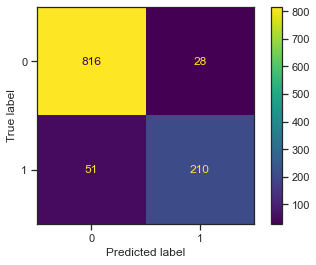

In [93]:
print("\n-----------------------------{}-----------------------------\n".format("Resnet 50"))
cm_val = confusion_matrix(y_val, yp_val_res)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val, yp_val_res))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val, yp_val_res),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val_res),4))
print("Precision on Val Data: ", round(precision_score(y_val, yp_val_res),4))
print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val_res),4))
print("--------------------------------------------------------------------------")
t2.plot()


-----------------------------Resnet 50-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2061
           1       0.87      0.85      0.86       701

    accuracy                           0.93      2762
   macro avg       0.91      0.90      0.90      2762
weighted avg       0.93      0.93      0.93      2762

--------------------------------------------------------------------------
Recall on Test Data:  0.8459
Specificity on Test Data:  0.9554
Accuracy on Test Data:  0.9276
Precision on Test Data:  0.8657
F1 Score Test Data:  0.8557
--------------------------------------------------------------------------


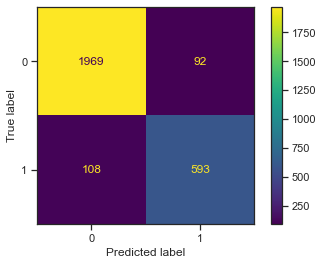

In [94]:
print("\n-----------------------------{}-----------------------------\n".format("Resnet 50"))
cm_test = confusion_matrix(y_test, yp_test_res)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test, yp_test_res))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test, yp_test_res), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test_res), 4))
print("Precision on Test Data: ", round(precision_score(y_test, yp_test_res), 4))
print("F1 Score Test Data: ", round(f1_score(y_test, yp_test_res), 4))
print("--------------------------------------------------------------------------")
t3.plot()

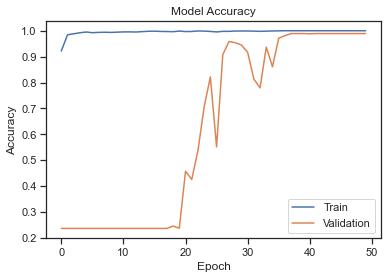

In [95]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

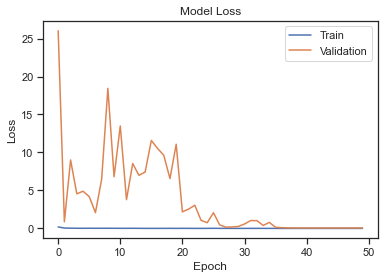

In [96]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

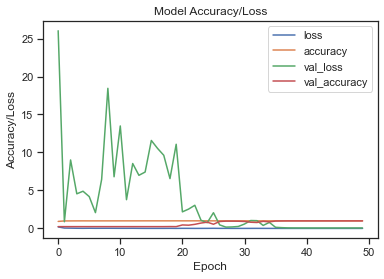

In [97]:
pd.DataFrame(history_4.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

# Voting Ensemble with CNN, VGG16, EfficientNetB3

In [98]:
y_train_all = np.concatenate((y_train,y_train,y_train))
yp_train_all = np.concatenate((yp_train,yp_train_vgg,yp_train_b3))
y_val_all = np.concatenate((y_val,y_val,y_val))
yp_val_all = np.concatenate((yp_val,yp_val_vgg,yp_val_b3))
yp_test_all = np.concatenate((yp_test,yp_test_vgg,yp_test_b3))
y_test_all = np.concatenate((y_test,y_test,y_test))

In [99]:
from collections import Counter
def find_majority(votes):
    vote_count = Counter(votes)
    top_two = vote_count.most_common(2)
    if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
        return 0
    return top_two[0][0]
print("Majority on Train data: ",find_majority(yp_train_all))
print("Majority on Val Data: ",find_majority(yp_val_all))
print("Majority on Test data: ",find_majority(yp_test_all))

Majority on Train data:  0
Majority on Val Data:  0
Majority on Test data:  0



-----------------------------Voting Ensemble with CNN, VGG16, EfficientNetB3-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     21861
           1       0.49      0.91      0.64      7962

    accuracy                           0.72     29823
   macro avg       0.72      0.78      0.71     29823
weighted avg       0.83      0.72      0.74     29823

--------------------------------------------------------------------------
Recall on Train Data:  0.9123
Specificity on Train Data:  0.6525
Accuracy on Train Data:  0.7219
Precision on Train Data:  0.4888
F1 Score on Train Data:  0.6366
--------------------------------------------------------------------------


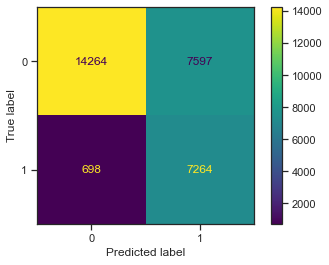

In [100]:
print("\n-----------------------------{}-----------------------------\n".format("Voting Ensemble with CNN, VGG16, EfficientNetB3"))
cm_train = confusion_matrix(y_train_all, yp_train_all)
t1 = ConfusionMatrixDisplay(cm_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
print("Classification Report for Train Data\n")
print(classification_report(y_train_all, yp_train_all)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train_all, yp_train_all),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train_all, yp_train_all),4))
print("Precision on Train Data: ", round(precision_score(y_train_all, yp_train_all),4))
print("F1 Score on Train Data: ", round(f1_score(y_train_all, yp_train_all),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------Voting Ensemble with CNN, VGG16, EfficientNetB3-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.94      0.65      0.77      2532
           1       0.43      0.87      0.58       783

    accuracy                           0.70      3315
   macro avg       0.69      0.76      0.67      3315
weighted avg       0.82      0.70      0.72      3315

--------------------------------------------------------------------------
Recall on Val Data:  0.8697
Specificity on Val Data:  0.6465
Accuracy on Val Data:  0.6992
Precision on Val Data:  0.4321
F1 Score on Val Data:  0.5774
--------------------------------------------------------------------------


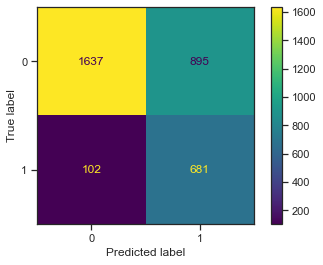

In [101]:
print("\n-----------------------------{}-----------------------------\n".format("Voting Ensemble with CNN, VGG16, EfficientNetB3"))
cm_val = confusion_matrix(y_val_all, yp_val_all)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val_all, yp_val_all))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val_all, yp_val_all),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val_all, yp_val_all),4))
print("Precision on Val Data: ", round(precision_score(y_val_all, yp_val_all),4))
print("F1 Score on Val Data: ", round(f1_score(y_val_all, yp_val_all),4))
print("--------------------------------------------------------------------------")
t2.plot()   


-----------------------------Voting Ensemble with CNN, VGG16, EfficientNetB3-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      6183
           1       0.46      0.88      0.60      2103

    accuracy                           0.70      8286
   macro avg       0.70      0.76      0.68      8286
weighted avg       0.82      0.70      0.72      8286

--------------------------------------------------------------------------
Recall on Test Data:  0.8811
Specificity on Test Data:  0.6432
Accuracy on Test Data:  0.7036
Precision on Test Data:  0.4565
F1 Score Test Data:  0.6014
--------------------------------------------------------------------------


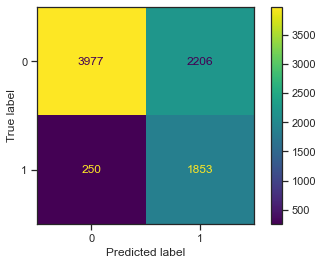

In [102]:
print("\n-----------------------------{}-----------------------------\n".format("Voting Ensemble with CNN, VGG16, EfficientNetB3"))
cm_test = confusion_matrix(y_test_all, yp_test_all)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test_all, yp_test_all))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test_all, yp_test_all), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test_all, yp_test_all), 4))
print("Precision on Test Data: ", round(precision_score(y_test_all, yp_test_all), 4))
print("F1 Score Test Data: ", round(f1_score(y_test_all, yp_test_all), 4))
print("--------------------------------------------------------------------------")
t3.plot()

# Voting Ensemble with CNN, VGG16, Resnet 50

In [103]:
yp_train_all2 = np.concatenate((yp_train,yp_train_vgg,yp_train_res))
yp_val_all2 = np.concatenate((yp_val,yp_val_vgg,yp_val_res))
yp_test_all2 = np.concatenate((yp_test,yp_test_vgg,yp_test_res))
# **แล้วเข้าตัวรนี้ ก่อน ไปทำ report

In [104]:
from collections import Counter
def find_majority(votes):
    vote_count = Counter(votes)
    top_two = vote_count.most_common(2)
    if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
        return 0
    return top_two[0][0]
print("Majority on Train data: ",find_majority(yp_train_all2))
print("Majority on Val Data: ",find_majority(yp_val_all2))
print("Majority on Test data: ",find_majority(yp_test_all2))

Majority on Train data:  0
Majority on Val Data:  0
Majority on Test data:  0



-----------------------------Voting Ensemble with CNN, VGG16, Resnet 50-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     21861
           1       0.94      0.88      0.90      7962

    accuracy                           0.95     29823
   macro avg       0.95      0.93      0.94     29823
weighted avg       0.95      0.95      0.95     29823

--------------------------------------------------------------------------
Recall on Train Data:  0.8754
Specificity on Train Data:  0.9779
Accuracy on Train Data:  0.9505
Precision on Train Data:  0.9352
F1 Score on Train Data:  0.9043
--------------------------------------------------------------------------


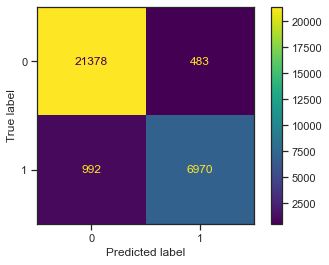

In [105]:
print("\n-----------------------------{}-----------------------------\n".format("Voting Ensemble with CNN, VGG16, Resnet 50"))
cm_train = confusion_matrix(y_train_all, yp_train_all2)
t1 = ConfusionMatrixDisplay(cm_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
print("Classification Report for Train Data\n")
print(classification_report(y_train_all, yp_train_all2)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train_all, yp_train_all2),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train_all, yp_train_all2),4))
print("Precision on Train Data: ", round(precision_score(y_train_all, yp_train_all2),4))
print("F1 Score on Train Data: ", round(f1_score(y_train_all, yp_train_all2),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------Voting Ensemble with CNN, VGG16, Resnet 50-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2532
           1       0.89      0.80      0.84       783

    accuracy                           0.93      3315
   macro avg       0.91      0.89      0.90      3315
weighted avg       0.93      0.93      0.93      3315

--------------------------------------------------------------------------
Recall on Val Data:  0.8046
Specificity on Val Data:  0.9688
Accuracy on Val Data:  0.93
Precision on Val Data:  0.8886
F1 Score on Val Data:  0.8445
--------------------------------------------------------------------------


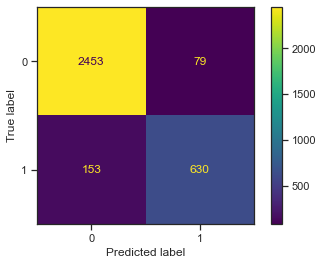

In [106]:
print("\n-----------------------------{}-----------------------------\n".format("Voting Ensemble with CNN, VGG16, Resnet 50"))
cm_val = confusion_matrix(y_val_all, yp_val_all2)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val_all, yp_val_all2))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val_all, yp_val_all2),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val_all, yp_val_all2),4))
print("Precision on Val Data: ", round(precision_score(y_val_all, yp_val_all2),4))
print("F1 Score on Val Data: ", round(f1_score(y_val_all, yp_val_all2),4))
print("--------------------------------------------------------------------------")
t2.plot()   


-----------------------------Voting Ensemble with CNN, VGG16, Resnet 50-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6183
           1       0.88      0.83      0.85      2103

    accuracy                           0.93      8286
   macro avg       0.91      0.90      0.90      8286
weighted avg       0.93      0.93      0.93      8286

--------------------------------------------------------------------------
Recall on Test Data:  0.8298
Specificity on Test Data:  0.9617
Accuracy on Test Data:  0.9282
Precision on Test Data:  0.8804
F1 Score Test Data:  0.8543
--------------------------------------------------------------------------


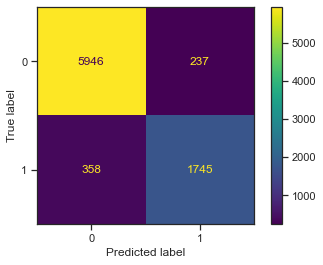

In [107]:
print("\n-----------------------------{}-----------------------------\n".format("Voting Ensemble with CNN, VGG16, Resnet 50"))
cm_test = confusion_matrix(y_test_all, yp_test_all2)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test_all, yp_test_all2))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test_all, yp_test_all2), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test_all, yp_test_all2), 4))
print("Precision on Test Data: ", round(precision_score(y_test_all, yp_test_all2), 4))
print("F1 Score Test Data: ", round(f1_score(y_test_all, yp_test_all2), 4))
print("--------------------------------------------------------------------------")
t3.plot()

# Voting Ensemble all

In [108]:
y_train_all3 = np.concatenate((y_train,y_train,y_train,y_train))
yp_train_all3 = np.concatenate((yp_train,yp_train_vgg,yp_train_b3,yp_train_res))
y_val_all3 = np.concatenate((y_val,y_val,y_val,y_val))
yp_val_all3 = np.concatenate((yp_val,yp_val_vgg,yp_val_b3,yp_val_res))
yp_test_all3 = np.concatenate((yp_test,yp_test_vgg,yp_test_b3,yp_test_res))
y_test_all3 = np.concatenate((y_test,y_test,y_test,y_test))

In [109]:
from collections import Counter
def find_majority(votes):
    vote_count = Counter(votes)
    top_two = vote_count.most_common(2)
    if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
        return 0
    return top_two[0][0]
print("Majority on Train data: ",find_majority(yp_train_all3))
print("Majority on Val Data: ",find_majority(yp_val_all3))
print("Majority on Test data: ",find_majority(yp_test_all3))

Majority on Train data:  0
Majority on Val Data:  0
Majority on Test data:  0



-----------------------------ALL-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     29148
           1       0.55      0.91      0.69     10616

    accuracy                           0.78     39764
   macro avg       0.75      0.82      0.76     39764
weighted avg       0.85      0.78      0.79     39764

--------------------------------------------------------------------------
Recall on Train Data:  0.9066
Specificity on Train Data:  0.7334
Accuracy on Train Data:  0.7796
Precision on Train Data:  0.5533
F1 Score on Train Data:  0.6872
--------------------------------------------------------------------------


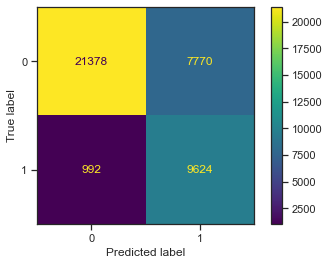

In [110]:
print("\n-----------------------------{}-----------------------------\n".format("ALL"))
cm_train = confusion_matrix(y_train_all3, yp_train_all3)
t1 = ConfusionMatrixDisplay(cm_train)
s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
print("Classification Report for Train Data\n")
print(classification_report(y_train_all3, yp_train_all3)) 
print("--------------------------------------------------------------------------")
print("Recall on Train Data: ", round(recall_score(y_train_all3, yp_train_all3),4))
print("Specificity on Train Data: ", s1)
print("Accuracy on Train Data: ", round(accuracy_score(y_train_all3, yp_train_all3),4))
print("Precision on Train Data: ", round(precision_score(y_train_all3, yp_train_all3),4))
print("F1 Score on Train Data: ", round(f1_score(y_train_all3, yp_train_all3),4))
print("--------------------------------------------------------------------------")
t1.plot()


-----------------------------ALL-----------------------------


Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.94      0.73      0.82      3376
           1       0.49      0.85      0.62      1044

    accuracy                           0.76      4420
   macro avg       0.72      0.79      0.72      4420
weighted avg       0.83      0.76      0.77      4420

--------------------------------------------------------------------------
Recall on Val Data:  0.8534
Specificity on Val Data:  0.7266
Accuracy on Val Data:  0.7566
Precision on Val Data:  0.4912
F1 Score on Val Data:  0.6235
--------------------------------------------------------------------------


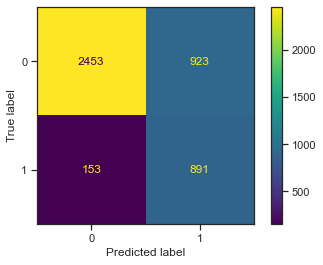

In [111]:
print("\n-----------------------------{}-----------------------------\n".format("ALL"))
cm_val = confusion_matrix(y_val_all3, yp_val_all3)
t2 = ConfusionMatrixDisplay(cm_val)
s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
print("\nClassification Report for Validation Data\n")
print(classification_report(y_val_all3, yp_val_all3))   
print("--------------------------------------------------------------------------")
print("Recall on Val Data: ", round(recall_score(y_val_all3, yp_val_all3),4))
print("Specificity on Val Data: ", s2)
print("Accuracy on Val Data: ", round(accuracy_score(y_val_all3, yp_val_all3),4))
print("Precision on Val Data: ", round(precision_score(y_val_all3, yp_val_all3),4))
print("F1 Score on Val Data: ", round(f1_score(y_val_all3, yp_val_all3),4))
print("--------------------------------------------------------------------------")
t2.plot()  


-----------------------------ALL-----------------------------


Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      8244
           1       0.52      0.87      0.65      2804

    accuracy                           0.76     11048
   macro avg       0.73      0.80      0.73     11048
weighted avg       0.83      0.76      0.77     11048

--------------------------------------------------------------------------
Recall on Test Data:  0.8723
Specificity on Test Data:  0.7213
Accuracy on Test Data:  0.7596
Precision on Test Data:  0.5156
F1 Score Test Data:  0.6481
--------------------------------------------------------------------------


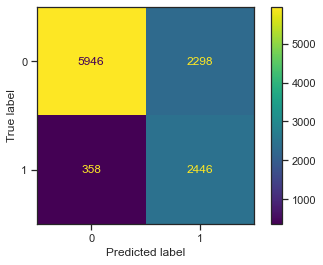

In [112]:
print("\n-----------------------------{}-----------------------------\n".format("ALL"))
cm_test = confusion_matrix(y_test_all3, yp_test_all3)
t3 = ConfusionMatrixDisplay(cm_test)
s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
print("\nClassification Report for Test Data\n")
print(classification_report(y_test_all3, yp_test_all3))   
print("--------------------------------------------------------------------------")
print("Recall on Test Data: ", round(recall_score(y_test_all3, yp_test_all3), 4))
print("Specificity on Test Data: ", s3)
print("Accuracy on Test Data: ", round(accuracy_score(y_test_all3, yp_test_all3), 4))
print("Precision on Test Data: ", round(precision_score(y_test_all3, yp_test_all3), 4))
print("F1 Score Test Data: ", round(f1_score(y_test_all3, yp_test_all3), 4))
print("--------------------------------------------------------------------------")
t3.plot()

# Conclusion

## All models

In [113]:
CNN = pd.DataFrame(
    { "Recall": [round(recall_score(y_train, yp_train),4),round(recall_score(y_val, yp_val),4),round(recall_score(y_test, yp_test), 4)],
      "Accuracy": [round(accuracy_score(y_train, yp_train),4),round(accuracy_score(y_val, yp_val),4),round(accuracy_score(y_test, yp_test), 4)],
      "Precision": [round(precision_score(y_train, yp_train),4),round(precision_score(y_val, yp_val),4),round(precision_score(y_test, yp_test), 4)],
      "F1 Score": [round(f1_score(y_train, yp_train),4),round(f1_score(y_val, yp_val),4),round(f1_score(y_test, yp_test), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("CNN")
print(CNN)
VGG16 = pd.DataFrame(
    { "Recall": [round(recall_score(y_train, yp_train_vgg),4),round(recall_score(y_val, yp_val_vgg),4),round(recall_score(y_test, yp_test_vgg), 4)],
      "Accuracy": [round(accuracy_score(y_train, yp_train_vgg),4),round(accuracy_score(y_val, yp_val_vgg),4),round(accuracy_score(y_test, yp_test_vgg), 4)],
      "Precision": [round(precision_score(y_train, yp_train_vgg),4),round(precision_score(y_val, yp_val_vgg),4),round(precision_score(y_test, yp_test_vgg), 4)],
      "F1 Score": [round(f1_score(y_train, yp_train_vgg),4),round(f1_score(y_val, yp_val_vgg),4),round(f1_score(y_test, yp_test_vgg), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("VGG16")
print(VGG16)
EB3 = pd.DataFrame(
    { "Recall": [round(recall_score(y_train, yp_train_b3),4),round(recall_score(y_val, yp_val_b3),4),round(recall_score(y_test, yp_test_b3), 4)],
      "Accuracy": [round(accuracy_score(y_train, yp_train_b3),4),round(accuracy_score(y_val, yp_val_b3),4),round(accuracy_score(y_test, yp_test_b3), 4)],
      "Precision": [round(precision_score(y_train, yp_train_b3),4),round(precision_score(y_val, yp_val_b3),4),round(precision_score(y_test, yp_test_b3), 4)],
      "F1 Score": [round(f1_score(y_train, yp_train_b3),4),round(f1_score(y_val, yp_val_b3),4),round(f1_score(y_test, yp_test_b3), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("EfficientNetB3")
print(EB3)
res = pd.DataFrame(
    { "Recall": [round(recall_score(y_train, yp_train_res),4),round(recall_score(y_val, yp_val_res),4),round(recall_score(y_test, yp_test_res), 4)],
      "Accuracy": [round(accuracy_score(y_train, yp_train_res),4),round(accuracy_score(y_val, yp_val_res),4),round(accuracy_score(y_test, yp_test_res), 4)],
      "Precision": [round(precision_score(y_train, yp_train_res),4),round(precision_score(y_val, yp_val_res),4),round(precision_score(y_test, yp_test_res), 4)],
      "F1 Score": [round(f1_score(y_train, yp_train_res),4),round(f1_score(y_val, yp_val_res),4),round(f1_score(y_test, yp_test_res), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("Resnet 50")
print(res)

CNN
                 Recall  Accuracy  Precision  F1 Score
Train Data       0.8478    0.9456     0.9426    0.8927
Validation Data  0.8046    0.9330     0.9013    0.8502
Test Data        0.7974    0.9294     0.9134    0.8515
VGG16
                 Recall  Accuracy  Precision  F1 Score
Train Data       0.8892    0.9530     0.9317    0.9100
Validation Data  0.8046    0.9285     0.8824    0.8417
Test Data        0.8459    0.9276     0.8657    0.8557
EfficientNetB3
                 Recall  Accuracy  Precision  F1 Score
Train Data          1.0    0.2670     0.2670    0.4214
Validation Data     1.0    0.2362     0.2362    0.3821
Test Data           1.0    0.2538     0.2538    0.4049
Resnet 50
                 Recall  Accuracy  Precision  F1 Score
Train Data       0.8892    0.9530     0.9317    0.9100
Validation Data  0.8046    0.9285     0.8824    0.8417
Test Data        0.8459    0.9276     0.8657    0.8557


## All voting

In [114]:
vote = pd.DataFrame(
    { "Recall": [round(recall_score(y_train_all, yp_train_all),4),round(recall_score(y_val_all, yp_val_all),4),round(recall_score(y_test_all, yp_test_all), 4)],
      "Accuracy": [round(accuracy_score(y_train_all, yp_train_all),4),round(accuracy_score(y_val_all, yp_val_all),4),round(accuracy_score(y_test_all, yp_test_all), 4)],
      "Precision": [round(precision_score(y_train_all, yp_train_all),4),round(precision_score(y_val_all, yp_val_all),4),round(precision_score(y_test_all, yp_test_all), 4)],
      "F1 Score": [round(f1_score(y_train_all, yp_train_all),4),round(f1_score(y_val_all, yp_val_all),4),round(f1_score(y_test_all, yp_test_all), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("Ensemble with CNN, VGG16, EfficientNetB3")
print(vote)
vote2 = pd.DataFrame(
    { "Recall": [round(recall_score(y_train_all, yp_train_all2),4),round(recall_score(y_val_all, yp_val_all2),4),round(recall_score(y_test_all, yp_test_all2), 4)],
      "Accuracy": [round(accuracy_score(y_train_all, yp_train_all2),4),round(accuracy_score(y_val_all, yp_val_all2),4),round(accuracy_score(y_test_all, yp_test_all2), 4)],
      "Precision": [round(precision_score(y_train_all, yp_train_all2),4),round(precision_score(y_val_all, yp_val_all2),4),round(precision_score(y_test_all, yp_test_all2), 4)],
      "F1 Score": [round(f1_score(y_train_all, yp_train_all2),4),round(f1_score(y_val_all, yp_val_all2),4),round(f1_score(y_test_all, yp_test_all2), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("Ensemble with CNN, VGG16, Resnet50")
print(vote2)
vote3 = pd.DataFrame(
    { "Recall": [round(recall_score(y_train_all3, yp_train_all3),4),round(recall_score(y_val_all3, yp_val_all3),4),round(recall_score(y_test_all3, yp_test_all3), 4)],
      "Accuracy": [round(accuracy_score(y_train_all3, yp_train_all3),4),round(accuracy_score(y_val_all3, yp_val_all3),4),round(accuracy_score(y_test_all3, yp_test_all3), 4)],
      "Precision": [round(precision_score(y_train_all3, yp_train_all3),4),round(precision_score(y_val_all3, yp_val_all3),4),round(precision_score(y_test_all3, yp_test_all3), 4)],
      "F1 Score": [round(f1_score(y_train_all3, yp_train_all3),4),round(f1_score(y_val_all3, yp_val_all3),4),round(f1_score(y_test_all3, yp_test_all3), 4)]},
    index = ["Train Data","Validation Data","Test Data"])
print("ALL")
print(vote3)

Ensemble with CNN, VGG16, EfficientNetB3
                 Recall  Accuracy  Precision  F1 Score
Train Data       0.9123    0.7219     0.4888    0.6366
Validation Data  0.8697    0.6992     0.4321    0.5774
Test Data        0.8811    0.7036     0.4565    0.6014
Ensemble with CNN, VGG16, Resnet50
                 Recall  Accuracy  Precision  F1 Score
Train Data       0.8754    0.9505     0.9352    0.9043
Validation Data  0.8046    0.9300     0.8886    0.8445
Test Data        0.8298    0.9282     0.8804    0.8543
ALL
                 Recall  Accuracy  Precision  F1 Score
Train Data       0.9066    0.7796     0.5533    0.6872
Validation Data  0.8534    0.7566     0.4912    0.6235
Test Data        0.8723    0.7596     0.5156    0.6481


# Image Analysis using Grad-CAM
Config- Parameters

In [115]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []
last_conv_layer_name = "block14_sepconv2_act"
# Reading 2 Covid & 2 Normal Images for Grad-Cam Analysis
img_path = ["../Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1002.png",
            "../Dataset/COVID-19_Radiography_Dataset/COVID/COVID-101.png",
            "../Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10004.png",
            "../Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10002.png"]

Grad - CAM Algorithm

In [116]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = tf.keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array
# Top create heatmaps for the samples
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Heatmap

In [117]:
covid_noncovid_heatmap = []
for i in img_path:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

1/1 [==============================] - 1s 695ms/step


Creating a Superimposed Viz

In [118]:
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))
for i in range(len(img_path)):
    save_and_display_gradcam(img_path[i], covid_noncovid_heatmap[i])

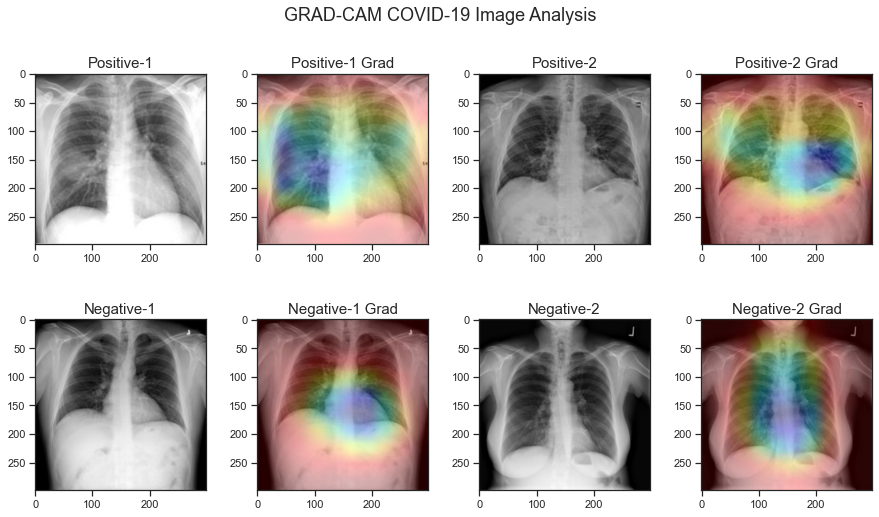

In [119]:
titles_list = ["Positive-1",'Positive-1 Grad','Positive-2','Positive-2 Grad','Negative-1','Negative-1 Grad','Negative-2','Negative-2 Grad']
plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")

Positive-1 Sample Insight: In its Grad-CAM image on the right mid part of it we can see the blue color highlighted portion which is opacity due to which it belongs to COVID - Positive Category.

Positive-2 Sample Insight: In its Grad-CAM image on the left bottom part of it we can see the blue green color highlighted portion which is consolidation and no Tree-Bud due to which it belongs to COVID - Positive Category.

Negative-1 Sample Insight: In its Grad-CAM image we can see the blue color highlighted portion which is between the Cardiac and Diaphragm and no any opacity was detected due to which it belongs to COVID - Negative Category.

Negative-2 Sample Insight: In its Grad-CAM image we can see the blue color portion which highlights the Trachea and no other opacity was detected due to which it belongs to COVID - Negative Category.

# Checking with Model

In [120]:
for i in img_path:
    z_img = cv2.imread(i)
    z_img = cv2.resize(z_img, (70, 70)) / 255.0
    z_img = z_img.reshape(1, z_img.shape[0], z_img.shape[1], z_img.shape[2])
    z = cnn_model.predict(z_img)
    z = np.argmax(z, axis = 1)
    print("Image", img_path.index(i) + 1, ":", z)

1/1 [==============================] - 0s 16ms/step
Image 1 : [0]
1/1 [==============================] - 0s 13ms/step
Image 2 : [0]
1/1 [==============================] - 0s 15ms/step
Image 3 : [0]
1/1 [==============================] - 0s 15ms/step
Image 4 : [0]


# Saving Model

In [121]:
cnn_model.save('cnn_model.h5')

# Conclusion

1. Done Exploratory Image Data Analysis on Covid vs Normal Images using various techniques.

2. Applied Convolutional Neural Network Model and got good Accuracy and Loss and prevented Overfitting.

3. Applied Grad - CAM Analysis on Sample Images and found few insights.